# Coloring manga

The goal of this project is to **realistically colorize manga pages**, which are very commonly only available in black and white. The colorizer should be specifically trained for coloring manga in an intuitive fashion, given that manga is typically more simple and stylized than real-life images. For this project, we train a conditional GAN based on the Pix2Pix model, which is described further in this [paper](https://arxiv.org/pdf/1611.07004).


Dataset: Manga109 dataset of colored manga covers. This dataset is notable because each of the authors of the 109 manga volumes used gave their express permission for usage in academia or research. 

Methodology: Instead of RGB, we use L\*a\*b space for each image in order to separate the greyscale component(L) from the colored components(a,b), where \*a represents green and red and \*b represents yellow and blue in a pixel. The GAN's generator will attempt to generate realistic a,b for a given L component, and the discriminator, given the same L, will attempt to deduce if the image is real or fake.



In [ ]:
import gan
sns.set_theme(palette = "magma")
!pip install jupyter_compare_view
from jupyter_compare_view import compare
#from google.colab import drive
#drive.mount('/content/drive')

## Training Pix2Pix cGAN model

The Pix2Pix model takes in paired images and attempts to predict the transformation that will convert one to the other. Some relevant examples of this include object detection, image colorization, image generation from an outline, image modification, etc. The model uses a conditional GAN methodology, which is described in further detail below.

In this case, we will be using it to convert black and white manga cover images to their colorized versions; this is an extremely applicable use case for pix2pix given that there innately exists a pair between b/w and colored images given a colored image, and this problem is a fairly simple colorization problem since digital art is inherently less complex and contains less information than real-life images. The dataset for this project is fairly small given that only colorized manga covers where the author has given permission for their usage are used, so we attempt to train a pix2pix model and see the results with our limited data.

In [2]:
dataset = datasets.load_dataset("goodfellowliu/Manga109")
dataset = dataset['train'].train_test_split(test_size = .2, seed = 1)
train_paths = np.array(range(len(dataset['train'])))
val_paths = np.array(range(len(dataset['test'])))
train_dl = make_dataloaders(paths=train_paths, split='train',ds = dataset['train'])
val_dl = make_dataloaders(paths=val_paths, split='val',ds = dataset['test'])

In [187]:
def train_model(model, train_dl, epochs, display_every=20):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

In [ ]:
model = MainModel()
train_model(model, train_dl, 3)

In [ ]:
torch.save(model,"/content/drive/MyDrive/projects/model.pt")

## Use trained model
We use the trained model to get predictions on unseen data that has either been previously colorized or is only available in black and white. In particular, manga covers are often in color, while manga pages are in black and white. 

**Try it yourself:** Add some images to the test or bwtest folder and see how the model colorizes. Or try the image slider to see how the model's prediction looks versus the real colored image!

As an example, the following is a visualization of the black and white version, the model-colorized version, and the correct version.

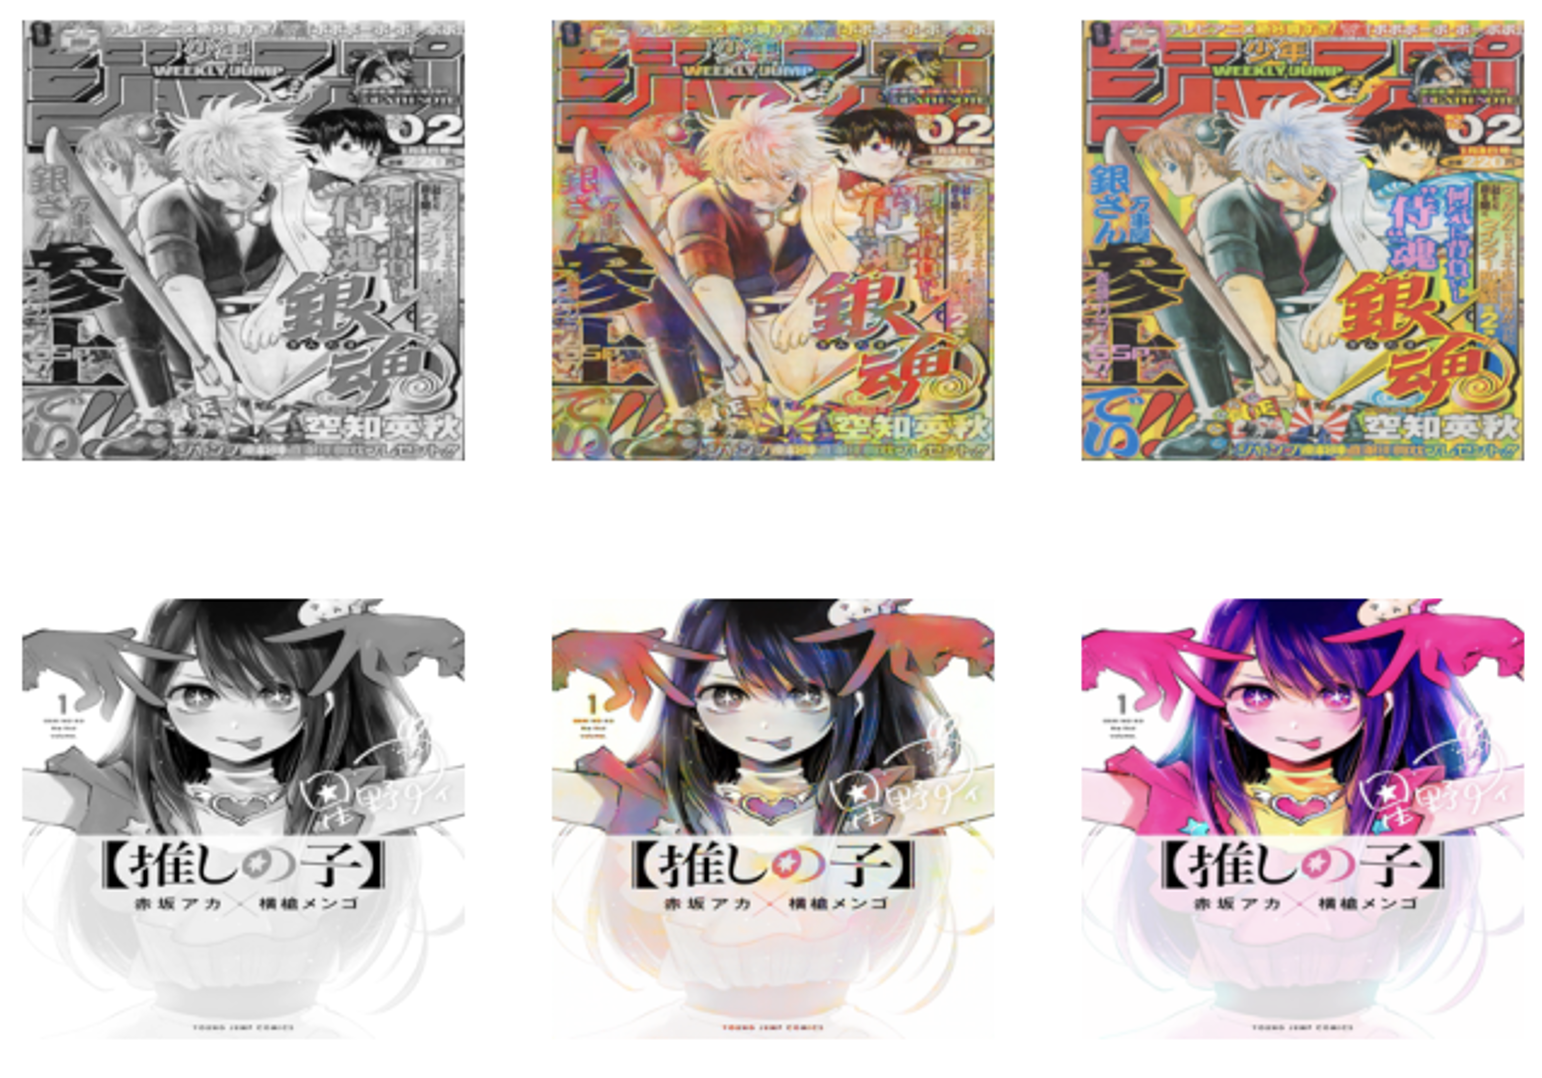

In [ ]:
#model = torch.load("/content/drive/MyDrive/projects/model.pt")
model = torch.load("model50.pt",map_location=torch.device('cpu'))
model.eval()

In [ ]:
#test on training/validation data which model has seen
data = iter(val_dl)
while data:
    visualize(model,next(data), save=False)
    

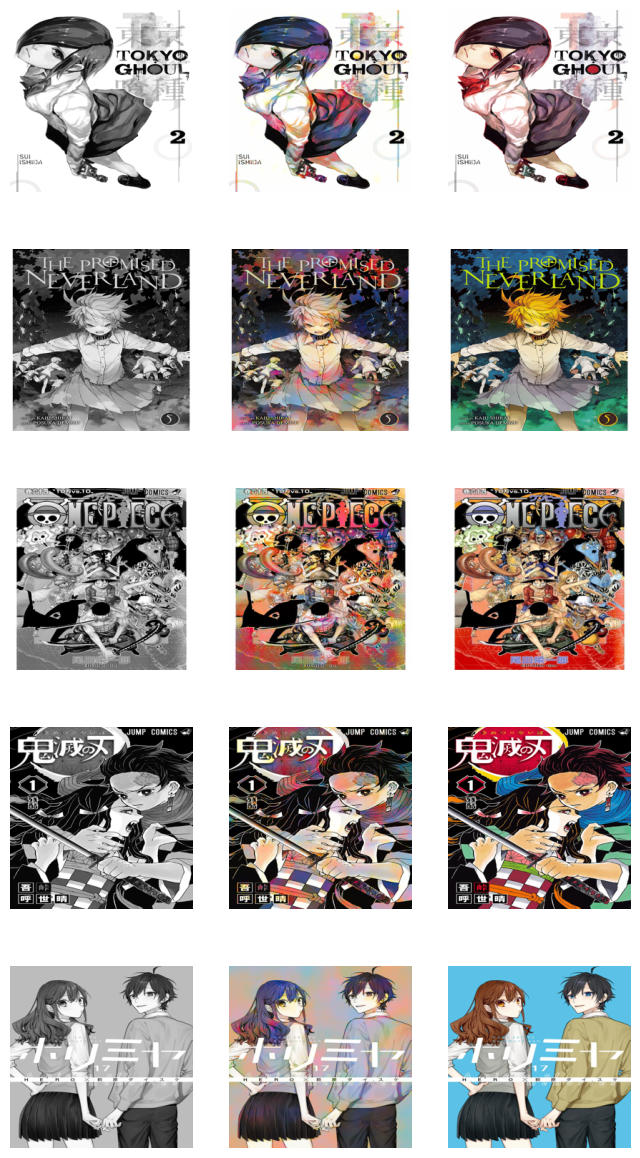

In [562]:
#test on new unseen data that has been colorized previously
test_dl = make_dataloaders(batch_size = 5, paths= np.array(range(len(os.listdir("test"))-2)), split='test', ds = None)
data = iter(test_dl)
visualize(model,next(data), save=False)

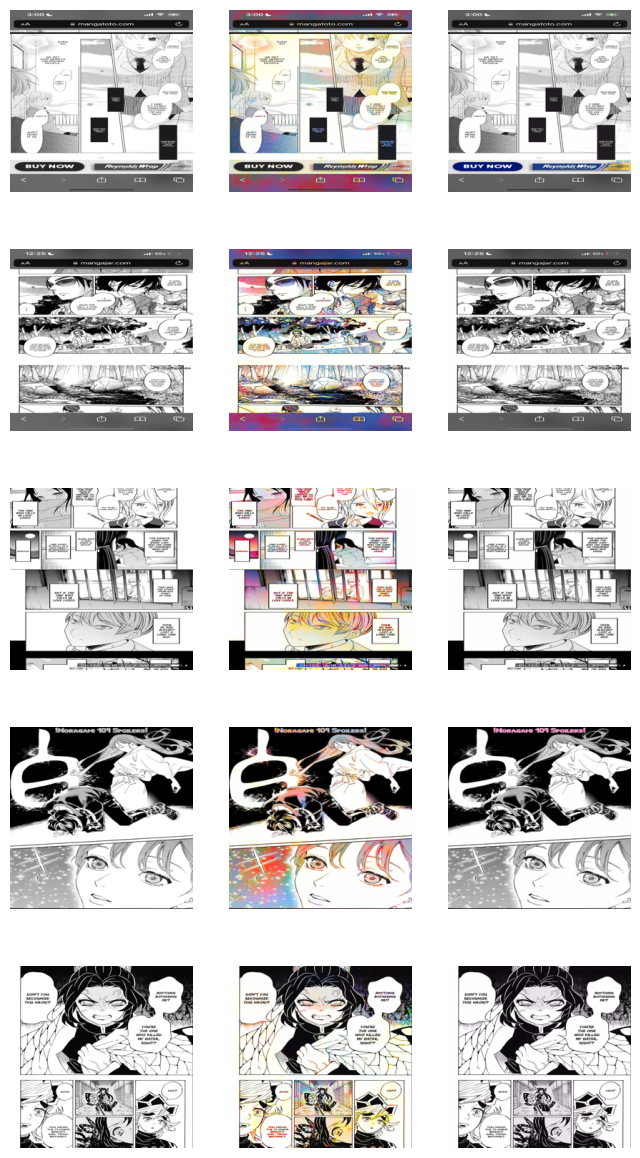

In [190]:
#test on unseen data that is originally black and white
bwtest_dl = make_dataloaders(batch_size = 5, paths= np.array(range(len(os.listdir("bwtest")))), split='bwtest', ds = None)
data = iter(bwtest_dl)
while (batch := next(data, None)) is not None:
    visualize(model,batch, save=False)

In [ ]:
full_test_dl = make_dataloaders(batch_size = len(os.listdir("test") ) - 2, paths= np.array(range(len(os.listdir("test"))-2)), split='test', ds = None)
data = next(iter(full_test_dl))
fake_color, real_color, L = getpred(model,data)
fake_imgs = lab_to_rgb(L, fake_color)
real_imgs = lab_to_rgb(L, real_color)


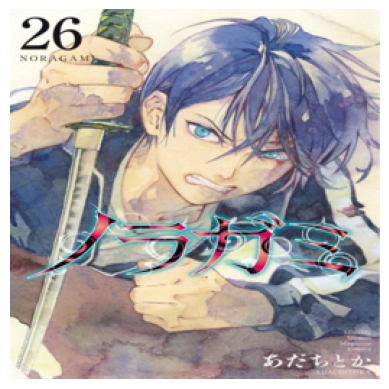
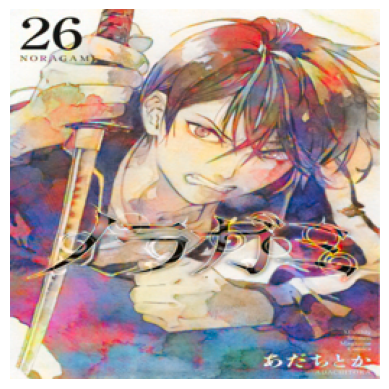

In [539]:
%%compare --height 400 --config '{"start_mode": "horizontal"}'
img = 14
#image slider- real on left, fake on right
plt.imshow(real_imgs[img])
plt.axis("off")
plt.show()
plt.imshow(fake_imgs[img])
plt.axis("off")
plt.show()

## Inference

### General Error Statistics and Visualization
Provides a comparison of error statistics between the train and test sets, in terms of the actual numerical range and in percentages.

Error statistics are calculated for overall mean absolute error, \*a/\*b mean absolute error, and \*a/\*b directional accuracy, calculated as percentage of pixels with correct \*a/\*b sign(e.g. red pixel is correctly predicted red instead of green).

In [518]:
print("Absolute Error - Train")

data = next(iter(train_dl))

Lreal_tr, Lfake_tr, Ldiff_tr, Ltf_tr, df = errordf(data)

df.round(2)

Absolute Error - Train


Mean   Std  *a Mean  *a Std  *b Mean  *b Std  \
Range (-110,110)  5.77  7.89     5.13    7.27     6.42    8.41   
Percentage        2.62  3.59     2.33    3.30     2.92    3.82   

                 *a Directional Acc *b Directional Acc  
Range (-110,110)             80.83%             84.12%  
Percentage                   80.83%             84.12%

In [519]:
print("Absolute Error - Test")
testdata = next(iter(full_test_dl))

Lreal, Lfake, Ldiff, Ltf, df = errordf(testdata)
df.round(2)

Absolute Error - Test


Mean    Std  *a Mean  *a Std  *b Mean  *b Std  \
Range (-110,110)  14.09  15.11    12.12   13.67    16.07   16.19   
Percentage         6.41   6.87     5.51    6.21     7.30    7.36   

                 *a Directional Acc *b Directional Acc  
Range (-110,110)             57.52%             58.95%  
Percentage                   57.52%             58.95%

Text(0.5, 1.0, 'a Error Difference')

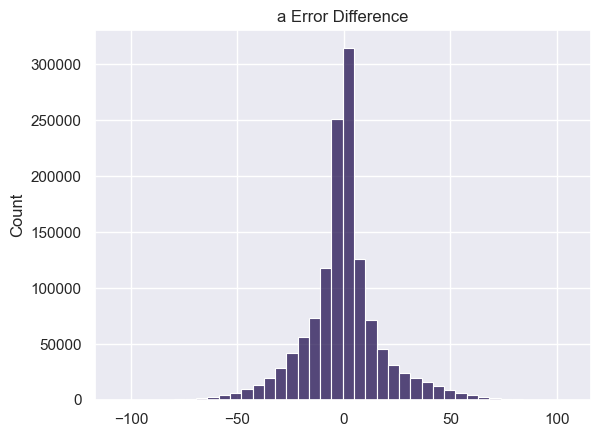

In [520]:
#we note approximately normal dist of directional error with mean 0, which is expected if model has some predictive power
adiff = Ldiff[:,:,:,1].reshape(-1, Ldiff[:,:,:,1].shape[-1]).flatten()
sns.histplot(adiff*110, bins = 40)
plt.title("a Error Difference")

Text(0.5, 1.0, 'b Error Difference')

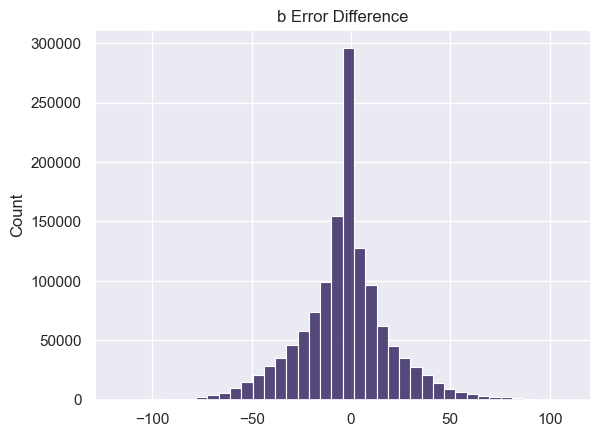

In [435]:
bdiff = Ldiff[:,:,:,2].reshape(-1, Ldiff[:,:,:,2].shape[-1]).flatten()
sns.histplot(bdiff*110, bins = 40)
plt.title("b Error Difference")

### Pixel Lightness

In [374]:
#a/b absolute error over different lightness bins
Ldiffsh = Ldiff.reshape(-1, Ldiff.shape[-1])
Ltfsh = Ltf.reshape(-1, Ltf.shape[-1])
Ldiffsh = pd.DataFrame(Ldiffsh, columns = ["L","a","b"])
Ldiffsh[["a dir","b dir"]] = Ltf.reshape(-1, Ltf.shape[-1])[:,1:]
Ldiffsh["L Binned"] = pd.cut(Ldiffsh["L"],10)


#### *a

Text(0.5, 1.0, 'Lightness Histogram - All Test Pixels')

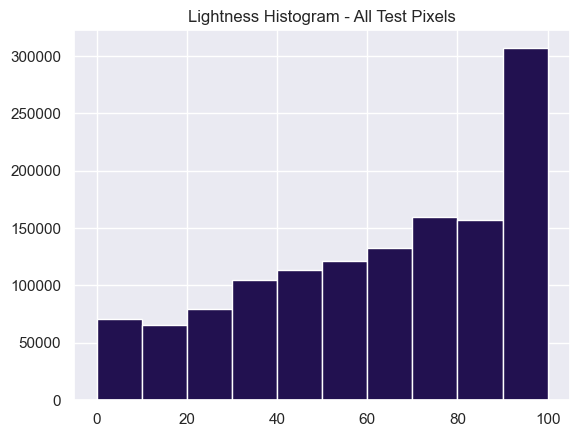

In [375]:
#data shows tendency towards lighter colors or white (near 100) as opposed to dark colors (near 0), which makes sense
#given that art pages are generally whitespace with black lineart and coloring
plt.hist(Ldiffsh["L"])
plt.title("Lightness Histogram - All Test Pixels")

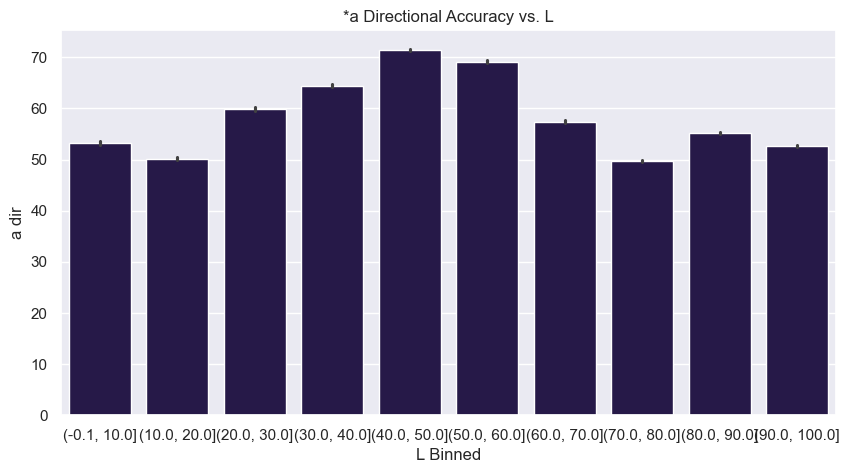

In [560]:
#a directional accuracy measured across lightness bins
plt.figure(figsize = (10,5))
sns.barplot(x = Ldiffsh["L Binned"], y = Ldiffsh["a dir"]*100)
plt.title("*a Directional Accuracy vs. L")
plt.show()

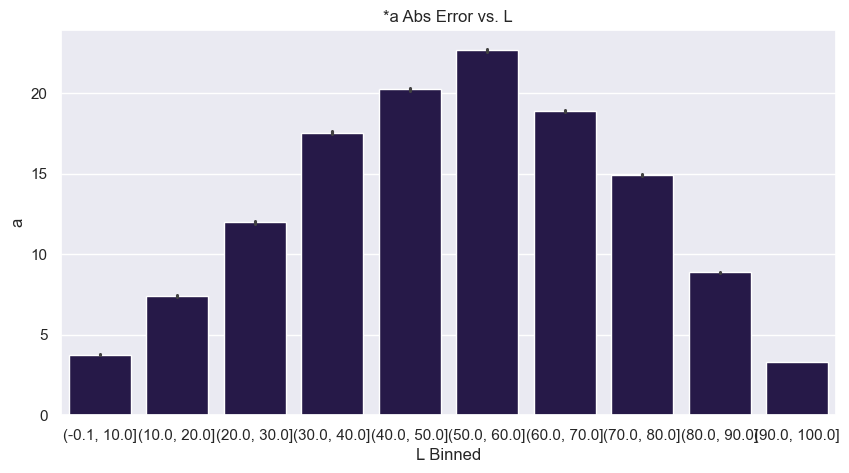

In [388]:
#the figure indicates that *a has highest error on average when the pixel is not extremely black or white
#we conjecture that this is because greyer pixels tend to be more colorful originally, so a higher magnitude *a value may have a
#tendency to have a more incorrect prediction
plt.figure(figsize = (10,5))
sns.barplot(x = Ldiffsh["L Binned"], y = abs(Ldiffsh["a"])*110)
plt.title("*a Abs Error vs. L")
plt.show()

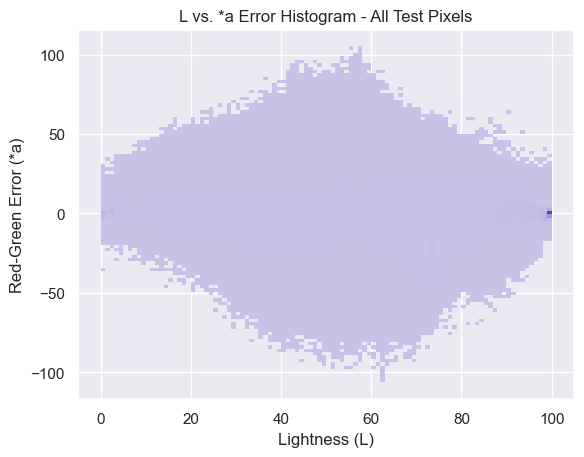

In [381]:
#we confirm this with a 2d histogram, further indicating that this is the case for both red and green
#directional error seems to be high for grey pixels that are red or green
sns.histplot(x =Ldiffsh["L"], y = Ldiffsh["a"]*110, bins = 100)
plt.xlabel("Lightness (L)")
plt.ylabel("Red-Green Error (*a)")
plt.title("L vs. *a Error Histogram - All Test Pixels")
plt.show()

#### *b

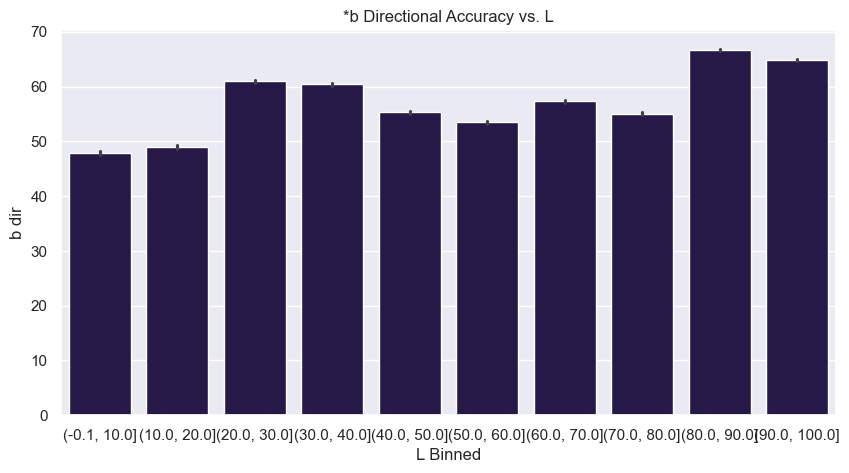

In [561]:
plt.figure(figsize = (10,5))
sns.barplot(x = Ldiffsh["L Binned"], y = Ldiffsh["b dir"]*100)
plt.title("*b Directional Accuracy vs. L")
plt.show()

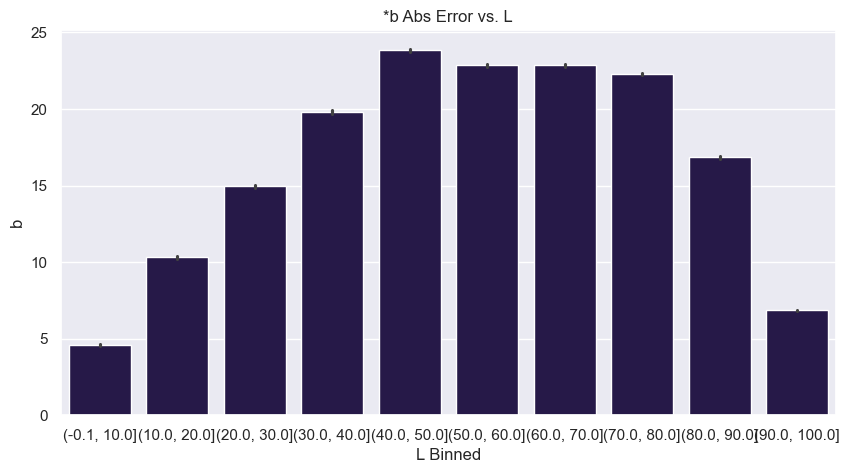

In [382]:
#we observe similar behavior for *b, such that highest error tends to occur when the pixel is not extremely black or white
plt.figure(figsize = (10,5))
sns.barplot(x = Ldiffsh["L Binned"], y = abs(Ldiffsh["b"])*110)
plt.title("*b Abs Error vs. L")
plt.show()

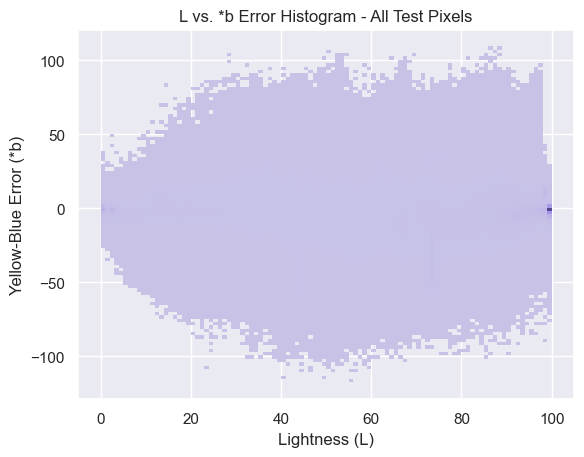

In [383]:
#similarly, the error is not particularly skewed towards yellow or blue, and both exhibit this pattern.
sns.histplot(x =Ldiffsh["L"], y = Ldiffsh["b"]*110, bins = 100)
plt.title("Lightness Histogram - All Test Pixels")
plt.xlabel("Lightness (L)")
plt.ylabel("Yellow-Blue Error (*b)")
plt.title("L vs. *b Error Histogram - All Test Pixels")
plt.show()

### Error Heatmapping

Text(0.5, 1.0, '*b Error')

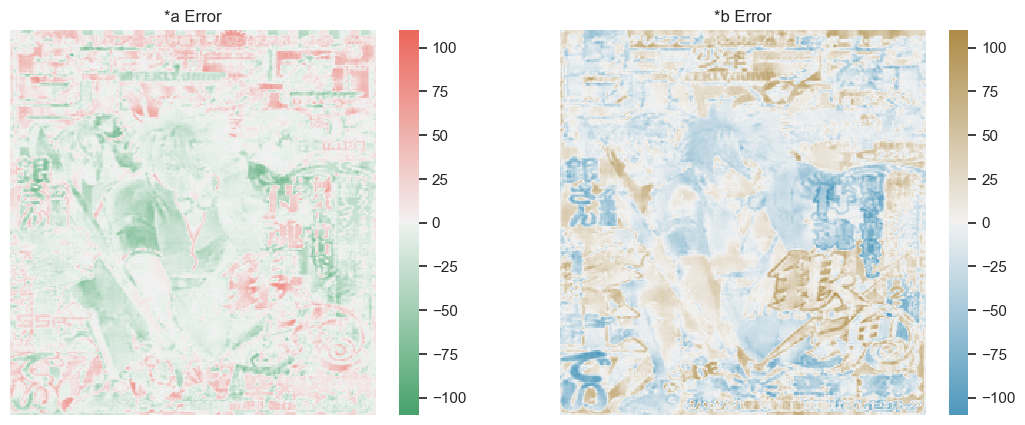

In [497]:
#heatmap of *a/*b difference from one real image

#choose test img idx
img = 15
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sns.heatmap(Ldiff[img,:,:,1]*110, vmin = -110, vmax = 110,cmap = sns.diverging_palette(140, 15, l = 60,as_cmap=True))
plt.axis('off')
plt.title("*b Error")
plt.subplot(1,2,2)
sns.heatmap(Ldiff[img,:,:,2]*110, vmin = -110, vmax = 110,cmap = sns.diverging_palette(230, 60, l = 60,as_cmap=True))
plt.axis('off')
plt.title("*b Error")


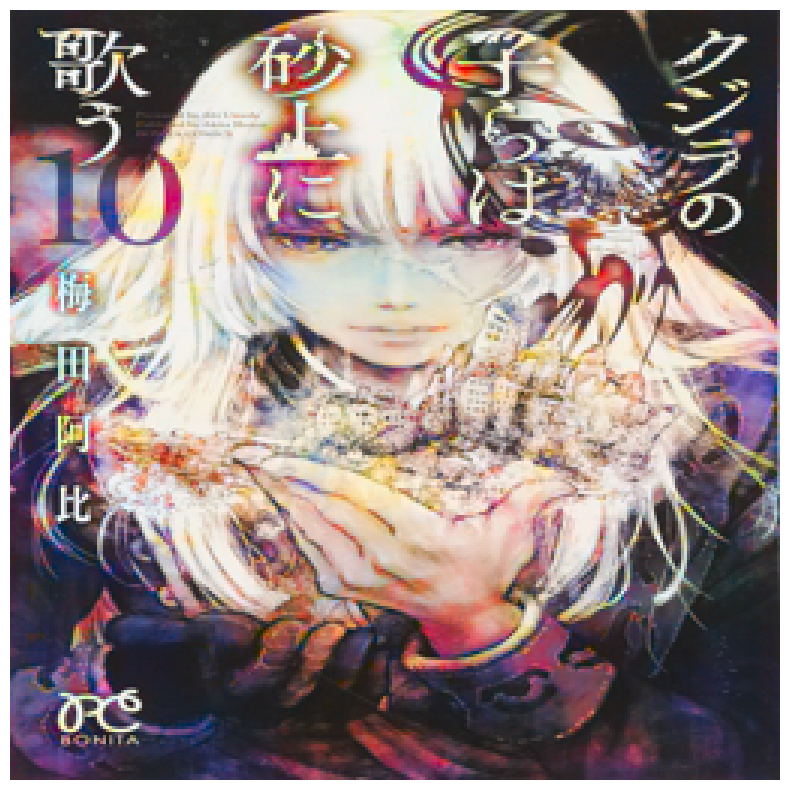
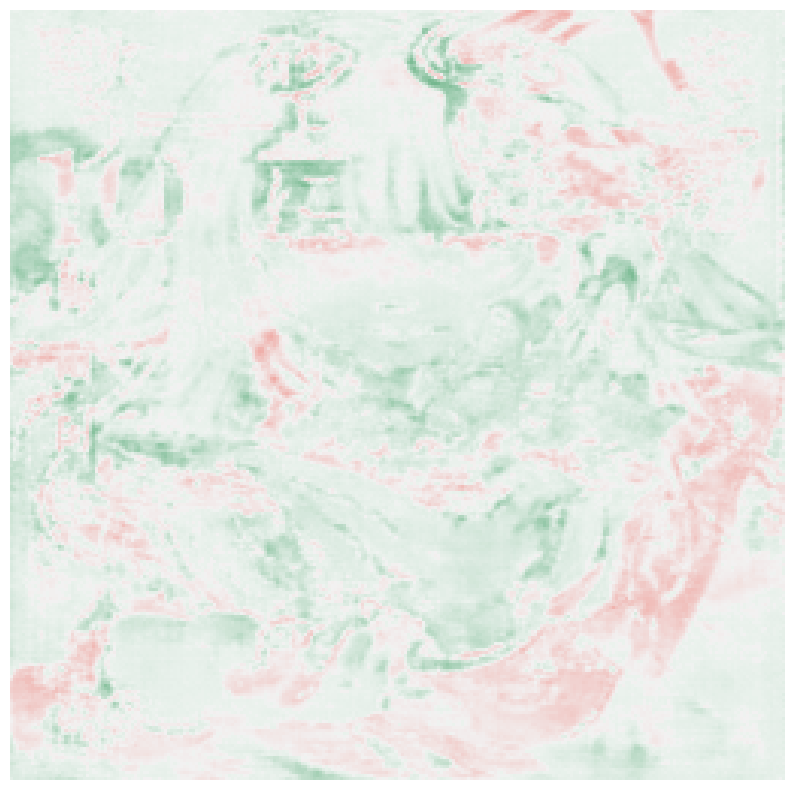
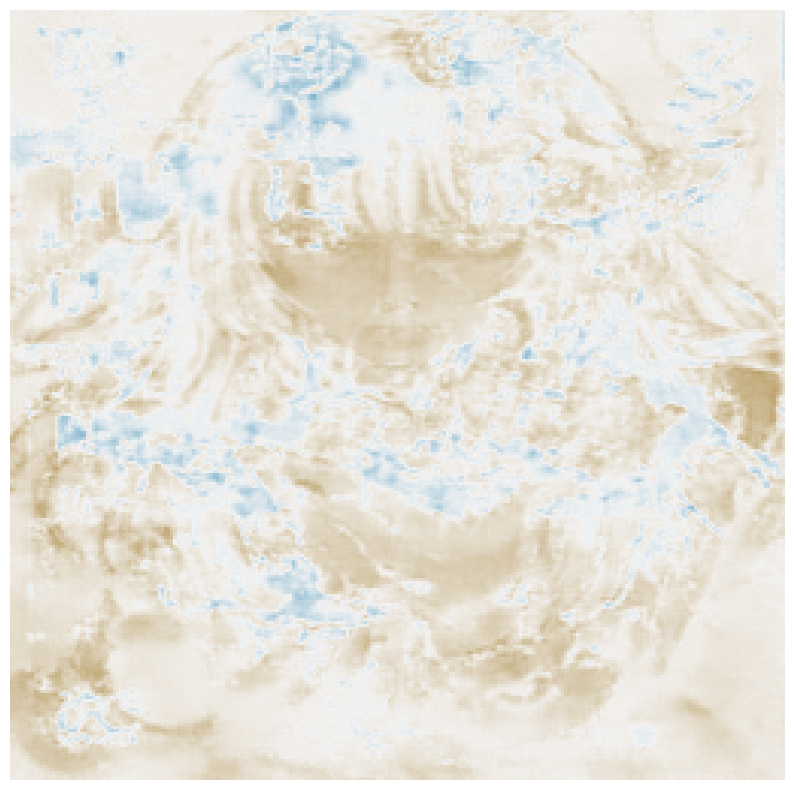

In [558]:
%%compare --height 400
img = 18
#RUN CURSOR OVER IMAGE
#image with circle slider shows predicted image + circle of a/b error

plt.figure(figsize = (10,10))
plt.imshow(fake_imgs[img])
plt.axis("off")
plt.show()

plt.figure(figsize = (10,10))
sns.heatmap(Ldiff[img,:,:,1]*110, vmin = -110, vmax = 110,cmap = sns.diverging_palette(140, 15, l = 60,as_cmap=True),cbar = False)
plt.axis('off')
plt.show()

plt.figure(figsize = (10,10))
sns.heatmap(Ldiff[img,:,:,2]*110, vmin = -110, vmax = 110,cmap = sns.diverging_palette(230, 60, l = 60,as_cmap=True), cbar = False)
plt.axis('off')
plt.show()

<Axes: >

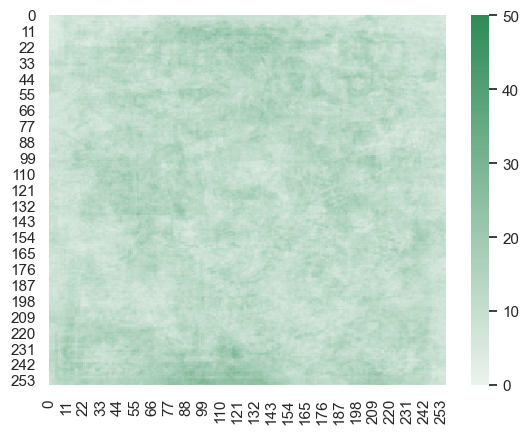

In [507]:
#heatmap of *a difference from real for all images, shows areas of most error in all images
#we do not see any areas of consistent significant deviation for *a
sns.heatmap(abs(Ldiff[:,:,:,1]*110).mean(0), vmin = 0, vmax = 50,cmap = sns.light_palette("seagreen", as_cmap=True))

<Axes: >

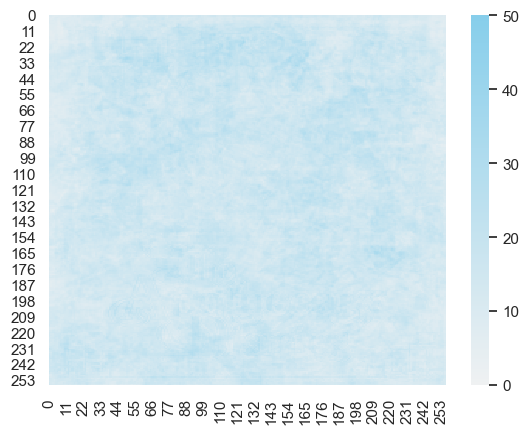

In [505]:
#heatmap of *b difference from real for all images, shows areas of most error in all images
#similarly we do not see any consistent areas of deviation here
sns.heatmap(abs(Ldiff[:,:,:,2]*110).mean(0), vmin = 0, vmax = 50,cmap = sns.light_palette("skyblue", as_cmap=True))